Saving dataset1.xls to dataset1.xls
=== Issue Type Classification Report ===
                    precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00        23
   Billing Problem       1.00      1.00      1.00        19
   General Inquiry       1.00      1.00      1.00        25
Installation Issue       1.00      1.00      1.00        29
     Late Delivery       1.00      1.00      1.00        17
    Product Defect       1.00      1.00      1.00        30
        Wrong Item       1.00      1.00      1.00        23

          accuracy                           1.00       166
         macro avg       1.00      1.00      1.00       166
      weighted avg       1.00      1.00      1.00       166

=== Urgency Level Classification Report ===
              precision    recall  f1-score   support

        High       0.38      0.35      0.37        66
         Low       0.30      0.35      0.32        43
      Medium       0.43      0.42      0.42        57

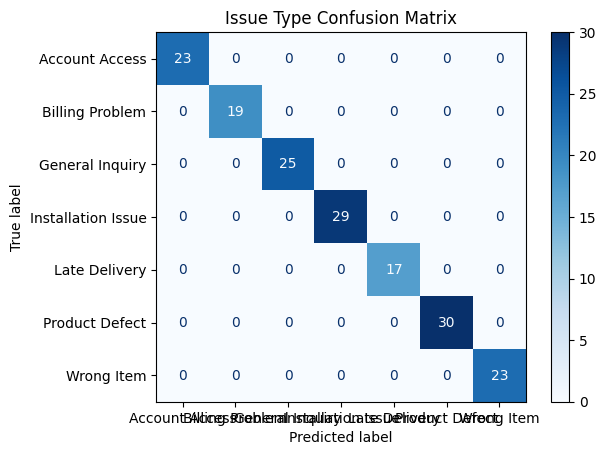

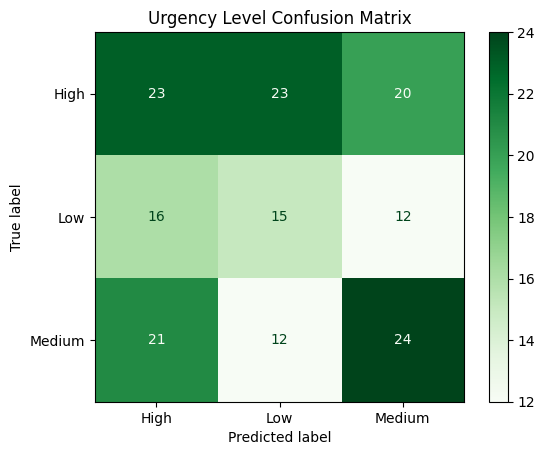

Issue Type CV F1: 1.0
Urgency Level CV F1: 0.3425530053562341
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d5e1e7341c3561358d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt_tab', quiet=True)

import pandas as pd
import numpy as np
import re, string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns

import gradio as gr

from google.colab import files
files.upload()


df = pd.read_excel("dataset1.xls")
df.dropna(subset=["ticket_text", "issue_type", "urgency_level"], inplace=True)
df["ticket_text"] = df["ticket_text"].astype(str)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["ticket_text"].apply(clean_text)

sia = SentimentIntensityAnalyzer()
df["ticket_length"] = df["ticket_text"].apply(len)
df["sentiment_score"] = df["ticket_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_text = tfidf.fit_transform(df["clean_text"])

X_extra = df[["ticket_length", "sentiment_score"]].values
X = hstack([X_text, X_extra])

X_train, X_test, y_issue_train, y_issue_test = train_test_split(
    X, df["issue_type"], test_size=0.2, random_state=42
)
_, _, y_urg_train, y_urg_test = train_test_split(
    X, df["urgency_level"], test_size=0.2, random_state=42
)

issue_model = LogisticRegression(max_iter=1000)
issue_model.fit(X_train, y_issue_train)
issue_preds = issue_model.predict(X_test)
print("=== Issue Type Classification Report ===")
print(classification_report(y_issue_test, issue_preds))

urgency_model = LogisticRegression(max_iter=1000)
urgency_model.fit(X_train, y_urg_train)
urgency_preds = urgency_model.predict(X_test)
print("=== Urgency Level Classification Report ===")
print(classification_report(y_urg_test, urgency_preds))

ConfusionMatrixDisplay.from_estimator(issue_model, X_test, y_issue_test, cmap="Blues")
plt.title("Issue Type Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(urgency_model, X_test, y_urg_test, cmap="Greens")
plt.title("Urgency Level Confusion Matrix")
plt.show()

issue_cv = cross_val_score(issue_model, X, df["issue_type"], cv=5, scoring="f1_weighted")
urg_cv = cross_val_score(urgency_model, X, df["urgency_level"], cv=5, scoring="f1_weighted")
print("Issue Type CV F1:", issue_cv.mean())
print("Urgency Level CV F1:", urg_cv.mean())

COMPLAINT_KEYWORDS = ["broken", "late", "error", "delay", "damaged", "refund", "not working"]
date_pattern = r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b'
product_list = df["product"].dropna().unique().tolist()

def extract_entities(text):
    return {
        "products": [p for p in product_list if p.lower() in text.lower()],
        "dates": re.findall(date_pattern, text),
        "complaints": [k for k in COMPLAINT_KEYWORDS if k in text.lower()]
    }

def predict_ticket(ticket_text):
    clean = clean_text(ticket_text)
    text_vec = tfidf.transform([clean])
    length = len(ticket_text)
    sentiment = sia.polarity_scores(ticket_text)["compound"]
    features = hstack([text_vec, [[length, sentiment]]])

    return {
        "issue_type": issue_model.predict(features)[0],
        "urgency_level": urgency_model.predict(features)[0],
        "entities": extract_entities(ticket_text)
    }

import gradio as gr

sample_tickets = [
    "My laptop stopped working after delivery on 12/10/2025. I need a refund ASAP.",
    "Smartphone battery is broken and the replacement was delayed.",
    "The software update caused an error and I can't login since yesterday.",
    "Package delivered late on 15/01/2026, missing items in the box.",
    "Headphones are damaged and I want a replacement."
]

def gradio_predict(ticket):
    r = predict_ticket(ticket)
    return r["issue_type"], r["urgency_level"], r["entities"]

interface = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Dropdown(choices=sample_tickets, label="Select a Sample Ticket"),
    outputs=[
        gr.Textbox(label="Predicted Issue Type"),
        gr.Textbox(label="Predicted Urgency Level"),
        gr.JSON(label="Extracted Entities")
    ],
    title="Customer Support Ticket Analyzer",
    description="Select a sample ticket to see predictions automatically."
)

interface.launch(share=True)



